In [1]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from sklearn.metrics import f1_score, classification_report,confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold



2024-12-10 22:17:08.608801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 22:17:08.627635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733861828.643681   87147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733861828.648551   87147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 22:17:08.672064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
IMG_ROWS = 64
IMG_COLS = 64
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 42
#Model
NO_EPOCHS = 50
BATCH_SIZE = 32

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # Set limit to 8GB

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert grayscale images (28x28x1) to 3 channels (28x28x3)
train_images = tf.repeat(train_images[..., tf.newaxis], 3, axis=-1)
test_images = tf.repeat(test_images[..., tf.newaxis], 3, axis=-1)

# Resize the from original model size of (224, 224, 3) images to a smaller size (64, 64) 
# due to VRAM limitations  
train_images = tf.image.resize(train_images, (64, 64))  
test_images = tf.image.resize(test_images, (64, 64))    

# One-hot encode the labels
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)



I0000 00:00:1733861831.758940   87147 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze the base model


/tmp/ipykernel_87147/3541323419.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


In [5]:
model = tf.keras.Sequential([
    # Input Layer
    tf.keras.layers.InputLayer(shape=(64, 64, 3)),

    # 1st CNN Layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'), # Custom CNN layer with 64 nodes
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    # 2nd CNN Layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'), # Custom CNN layer with 128 nodes
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    # 3rd CNN Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'), # Custom CNN layer with 256 nodes
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),

    # Flattening Layer
    tf.keras.layers.Flatten(),

    # Fully Connected Layer
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax), # Output layer for 10 classes
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,471,690 (9.43 MB)

 Trainable params: 2,470,538 (9.42 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
base_model.trainable = True

early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=25,                  # Stop training after 5 epochs without improvement
    verbose=1,                   # Print a message when stopping
    mode='min',                  # Looking for the minimum validation loss
    restore_best_weights=True,   # Restore weights from the best epoch
)


# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

history_finetune = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=150,
    batch_size=16,
    callbacks=[early_stopping]

)

#approx 53 mins to train

Epoch 1/150


I0000 00:00:1733861836.522030   87350 service.cc:148] XLA service 0x7f70dc007c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733861836.522076   87350 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-10 22:17:16.570134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733861836.792665   87350 cuda_dnn.cc:529] Loaded cuDNN version 90300


  13/3750 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.2174 - loss: 2.6532  

I0000 00:00:1733861840.424674   87350 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.7797 - loss: 1.0631 - val_accuracy: 0.8827 - val_loss: 0.7817
Epoch 2/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8748 - loss: 0.8489 - val_accuracy: 0.8827 - val_loss: 0.7685
Epoch 3/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8905 - loss: 0.8134 - val_accuracy: 0.9061 - val_loss: 0.7271
Epoch 4/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9017 - loss: 0.7907 - val_accuracy: 0.9097 - val_loss: 0.7154
Epoch 5/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9091 - loss: 0.7707 - val_accuracy: 0.9087 - val_loss: 0.7238
Epoch 6/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9151 - loss: 0.7603 - val_accuracy: 0.9121 - val_loss: 0.7078
Epoch 7/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9174 - loss: 0.7504 - val_accuracy: 0.9235 - val_loss: 0.6878
Epoch 8/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9236 - loss: 0.738

In [ ]:

#THIS LINE SAVES YOUR MODEL OUTPUT
model.save("/mnt/c/Users/zeiad/Downloads/ML-Project/model.keras")


In [7]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Get model predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert to label indices

# Convert true labels to label indices
true_labels = np.argmax(test_labels, axis=1)

# Compute the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"MobileNetV2 Accuracy: {test_accuracy}")
print(f"MobileNetV2 F1 score: {f1:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9427 - loss: 0.6480
Test accuracy: 94.38%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MobileNetV2 Accuracy: 0.9437999725341797
MobileNetV2 F1 score: 0.94


In [8]:
# Generate predictions on the test set
predictions = model.predict(test_images)

# Convert predicted probabilities to class indices
pred_y = np.argmax(predictions, axis=1)

# Convert one-hot encoded test labels to class indices
true_y = np.argmax(test_labels, axis=1)

# Print the classification report
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
print(classification_report(true_y, pred_y, target_names=label_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.90      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.93      0.92      0.92      1000
       Dress       0.94      0.95      0.94      1000
        Coat       0.92      0.93      0.92      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.83      0.82      0.83      1000
     Sneaker       0.97      0.99      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.99      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


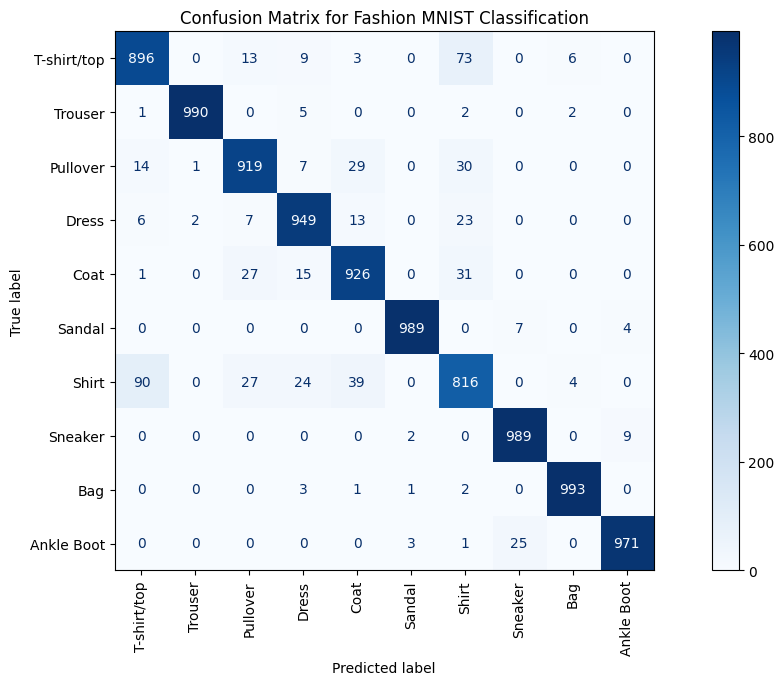

In [9]:
# Label names for Fashion MNIST
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Assume `model` is your trained model
# Generate predictions on the test dataset
predictions = model.predict(test_images, batch_size=16)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.xticks(rotation=90)
plt.title("Confusion Matrix for Fashion MNIST Classification")
plt.show()

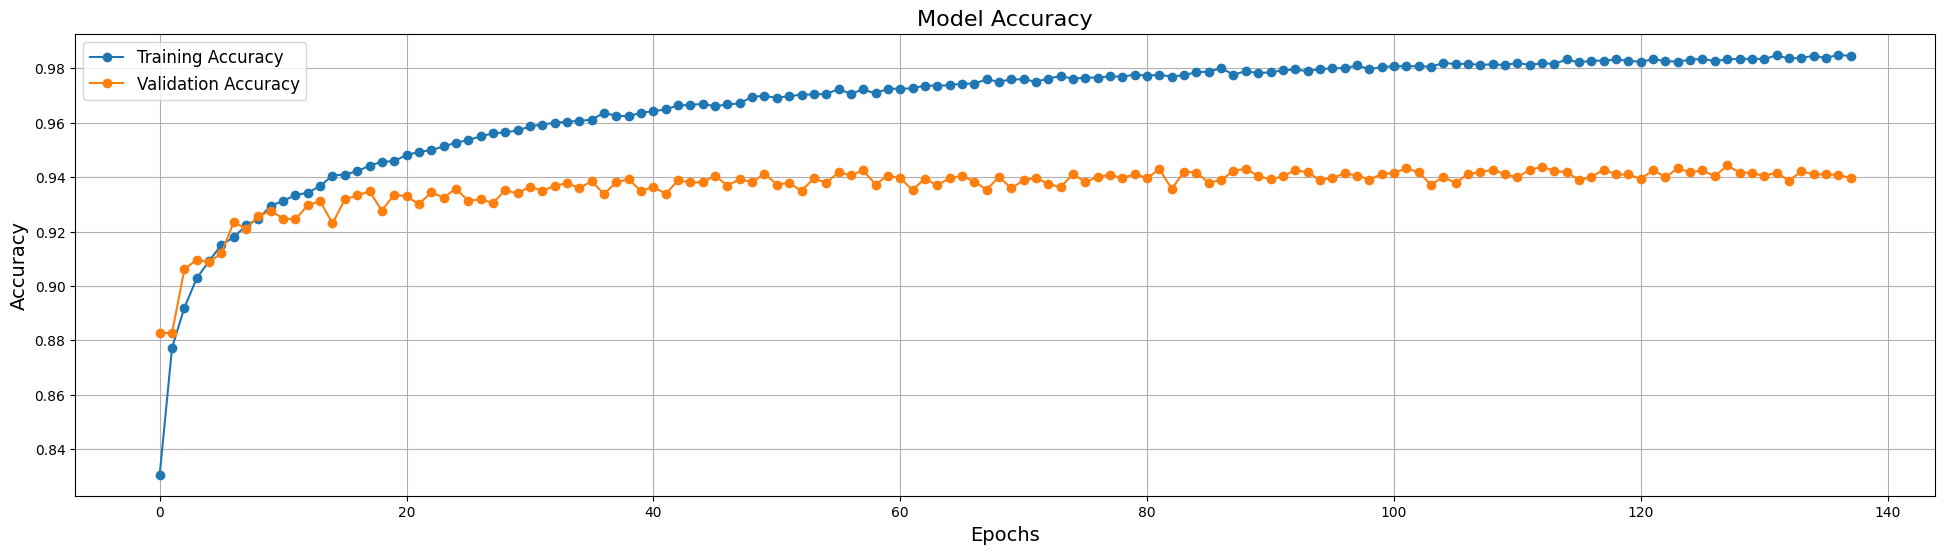

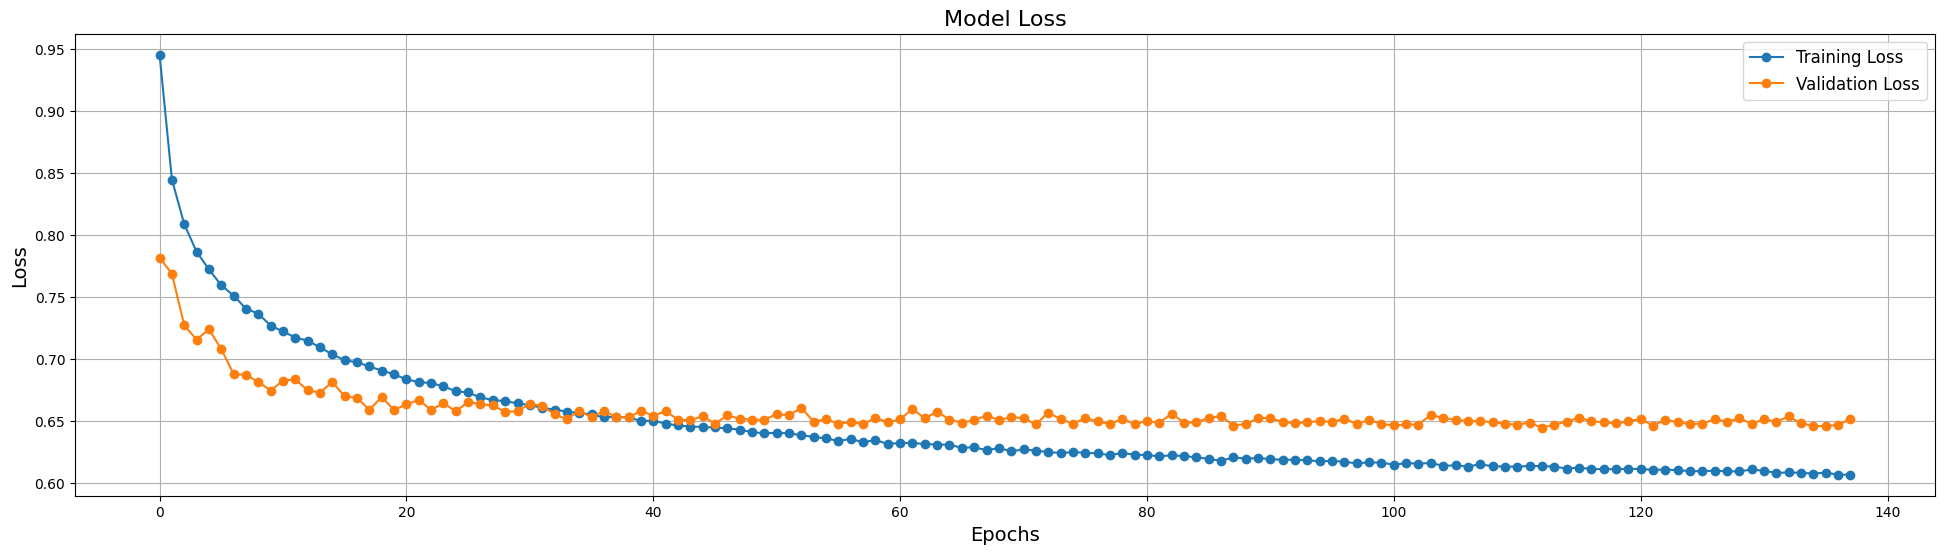

In [12]:
# Plot training history
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.figure(figsize=(24, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title('Model Accuracy', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(24, 6))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title('Model Loss', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()
plot_history([history_finetune], ["MobileNetV2"])